# MSE as a function of Training set size
## predicting time from minibatch size and GPU parameters

In [3]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess, os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
batch_learn_pattern = re.compile(r"^b\s*(\d+)\s+l\s*([0-9\.]+)")
output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")
remove_str="[J"


# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global batch_learn_pattern
    global output_pattern
    global remove_str
    logfile = logfile.strip(" \n")
    with open(logfile,"r") as f:
        lines = f.readlines()
        batch = 0
        time = 0
        epoch = 0
        ind = 0 # DataFrame row numebr (index)
        df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])
        for line in lines:
            s = line.strip(' \n')
            s = s.replace(remove_str,"")
            m = batch_learn_pattern.match(s)
            if m:
                batch = int(m.group(1))
                learn = float(m.group(2))
                if debug: print logfile,": b",batch," l",learn
            else:
                m2 = output_pattern.match(s)
                if m2:
                    epoch = int(m2.group(1))
                    time = float(m2.group(6))
                    if debug: print batch,learn,epoch,time
                    df.loc[ind] = [batch,learn,epoch,time]
                    ind += 1
                    
    return df

In [5]:
filename_pattern=re.compile(r"cifar_.*\.log")

def readLogs(logdir, debug=False):
    global filename_pattern
    list_command = "ls -1 "+logdir
    if debug: print "Looking in",logdir
    files=[]
    proc = subprocess.Popen(list_command.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    if debug: print len(files),"files"
    df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])

    for file in files:
        df1 = fileToDF(file,debug)
        if len(df1) > 0:
            df = pd.concat([df,df1],ignore_index=True)
    return df

In [6]:
!ls logs/microseries/

GTX_TITAN_X K80         QuadroP2000


In [8]:
df_mouse=readLogs("logs/microseries/QuadroP2000")
df_DLsrv=readLogs("logs/microseries/GTX_TITAN_X")
df_mouse.head()

,batch,learn,epoch,time
0,101.0,0.15,1.0,90.3823
1,101.0,0.15,1.0,90.4984
2,102.0,0.15,1.0,90.1218
3,103.0,0.15,1.0,90.1364
4,104.0,0.15,1.0,90.1099


In [9]:
def readLogsK80(logdir, debug=False):
    global filename_pattern    
    
    list_command = "ls -1 "+logdir
    files=[]
    proc = subprocess.Popen(list_command.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    if debug: maxfiles = 5
    else: maxfiles = 100000000
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])

    filecounter=0
    for file in files:
        if debug: print file
        df1 = fileToDF_K80(file,debug)
        if len(df1) > 0:
            df = pd.concat([df,df1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return df

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF_K80(logfile, debug=False):
    batch_learn_pattern = "_b(\d+)_l([0-9\.]+)"
    global output_pattern
    remove_str = ["[4A","[J"]
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    m = re.search(batch_learn_pattern, filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        if debug: print "BS,LR:",batch,learn

    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind = 0 # DataFrame row numebr (index)
        df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])
        for line in lines:
            s = line.strip(' \n')
            for rmstr in remove_str:
                s = s.replace(rmstr,"")            
            m2 = output_pattern.match(s)
            if m2:
                if debug: print s,
                epoch = int(m2.group(1))
                time = float(m2.group(6))
                if debug: print "BS,LR,epoch,time:",batch,learn,epoch,time
                df.loc[ind] = [batch,learn,epoch,time]
                ind += 1
                    
    return df

In [10]:
df_K80=readLogsK80("logs/microseries/K80")
df_K80.describe()

,batch,learn,epoch,time
count,266.000000,2.660000e+02,266.0,266.000000
mean,466.210526,1.500000e-01,1.0,169.938150
std,244.284911,2.780790e-17,0.0,17.175434
min,65.000000,1.500000e-01,1.0,87.221800
25%,246.000000,1.500000e-01,1.0,172.636000
50%,453.500000,1.500000e-01,1.0,173.322500
75%,683.000000,1.500000e-01,1.0,174.097500
max,895.000000,1.500000e-01,1.0,181.592000


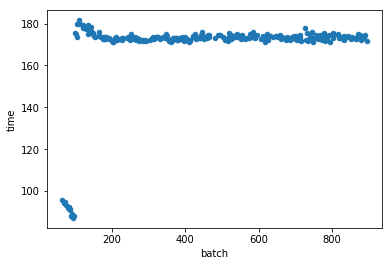

In [11]:
df_K80.plot(kind="scatter",x="batch",y="time")

In [12]:
print df_DLsrv.shape
print df_mouse.shape
print df_K80.shape

(961, 4)
(800, 4)
(266, 4)


In [13]:
GPUs_df = pd.DataFrame(columns=["GPU model","CUDA ver","CUDA Cap","CUDA cores","L2 size(MB)","SP (GFLOPS)","DP (GFLOPS)","Mem (GB)","Mband (GB/s)"],
                           data = [["GTX TITAN X",     9.0,       5.2,        3072,     3.145728,         6144,          192,    12.288,           336],
                                   ["QuadroP2000",     9.0,       6.1,        1024,     1.310720,         3000,         94.7,         5,           140],
                                   [        "K80",     9.0,       3.7,        2496,     1.572864,         8736,         2912,    12.288,           240]])
GPUs_df.head()                       

,GPU model,CUDA ver,CUDA Cap,CUDA cores,L2 size(MB),SP (GFLOPS),DP (GFLOPS),Mem (GB),Mband (GB/s)
0,GTX TITAN X,9.0,5.2,3072,3.145728,6144,192.0,12.288,336
1,QuadroP2000,9.0,6.1,1024,1.310720,3000,94.7,5.000,140
2,K80,9.0,3.7,2496,1.572864,8736,2912.0,12.288,240


In [14]:
df_DLsrv["GPU"] = "GTX TITAN X" # Single precision peak GFLOPS for GTX TITAN X
df_mouse["GPU"] = "QuadroP2000"
df_K80["GPU"] = "K80"
df_DLsrv.drop(["learn","epoch"],axis=1,inplace=True)
df_mouse.drop(["learn","epoch"],axis=1,inplace=True)
df_K80.drop(["learn","epoch"],axis=1,inplace=True)
print df_DLsrv.shape
df_mouse.head()

(961, 3)


,batch,time,GPU
0,101.0,90.3823,QuadroP2000
1,101.0,90.4984,QuadroP2000
2,102.0,90.1218,QuadroP2000
3,103.0,90.1364,QuadroP2000
4,104.0,90.1099,QuadroP2000


In [15]:
df_DLsrv.head()

,batch,time,GPU
0,1000.0,24.4252,GTX TITAN X
1,1001.0,24.4108,GTX TITAN X
2,1002.0,24.4341,GTX TITAN X
3,1003.0,24.7236,GTX TITAN X
4,1004.0,25.0943,GTX TITAN X


In [18]:
mdf = pd.concat([df_DLsrv,df_mouse,df_K80],ignore_index=True)
print mdf.shape
mdf.head()

(2027, 3)


,batch,time,GPU
0,1000.0,24.4252,GTX TITAN X
1,1001.0,24.4108,GTX TITAN X
2,1002.0,24.4341,GTX TITAN X
3,1003.0,24.7236,GTX TITAN X
4,1004.0,25.0943,GTX TITAN X


In [17]:
GPUs_df.rename({"GPU model":"GPU"},axis="columns",inplace=True)
GPUs_df.head()

,GPU,CUDA ver,CUDA Cap,CUDA cores,L2 size(MB),SP (GFLOPS),DP (GFLOPS),Mem (GB),Mband (GB/s)
0,GTX TITAN X,9.0,5.2,3072,3.145728,6144,192.0,12.288,336
1,QuadroP2000,9.0,6.1,1024,1.310720,3000,94.7,5.000,140
2,K80,9.0,3.7,2496,1.572864,8736,2912.0,12.288,240


In [19]:
# SQL-like join
df = pd.merge(mdf,GPUs_df,on="GPU")
df[df["GPU"]=="K80"].head()

,batch,time,GPU,CUDA ver,CUDA Cap,CUDA cores,L2 size(MB),SP (GFLOPS),DP (GFLOPS),Mem (GB),Mband (GB/s)
1761,101.0,174.921,K80,9.0,3.7,2496,1.572864,8736,2912.0,12.288,240
1762,104.0,173.678,K80,9.0,3.7,2496,1.572864,8736,2912.0,12.288,240
1763,105.0,179.941,K80,9.0,3.7,2496,1.572864,8736,2912.0,12.288,240
1764,110.0,181.592,K80,9.0,3.7,2496,1.572864,8736,2912.0,12.288,240
1765,112.0,179.857,K80,9.0,3.7,2496,1.572864,8736,2912.0,12.288,240


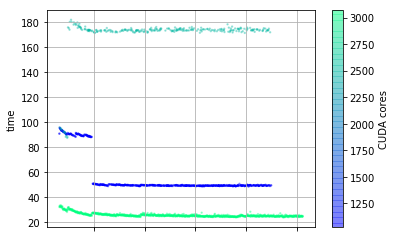

In [22]:
df.plot(kind="scatter",x="batch",y="time",c="CUDA cores",grid=True,alpha=0.3,s=2,colormap="winter")

## Prepare samples X and GT Y

In [27]:
X = df[["batch","Mem (GB)","Mband (GB/s)", "CUDA Cap", "CUDA cores", "L2 size(MB)"]].values
Y = df["time"].values
X.shape
X[:2]

array([[ 1000.      ,    12.288   ,   336.      ,     5.2     ,
         3072.      ,     3.145728],
       [ 1001.      ,    12.288   ,   336.      ,     5.2     ,
         3072.      ,     3.145728]])

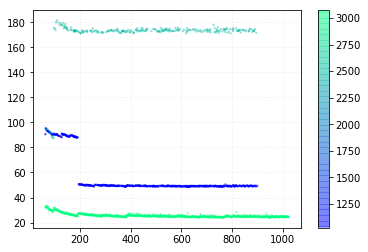

In [32]:
fig = plt.scatter(x=X[:,0],y=Y,c=X[:,4],s=2,alpha=0.3,cmap="winter")
plt.grid(linestyle=":",alpha=0.3)
plt.colorbar()
plt.show()

### Split samples to training and test sets

In [29]:
# Create training and test sets.
train_size=100
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, train_size=train_size, shuffle = True)

print X_train.shape,"x",X_test.shape

(100, 6) x (1927, 6)


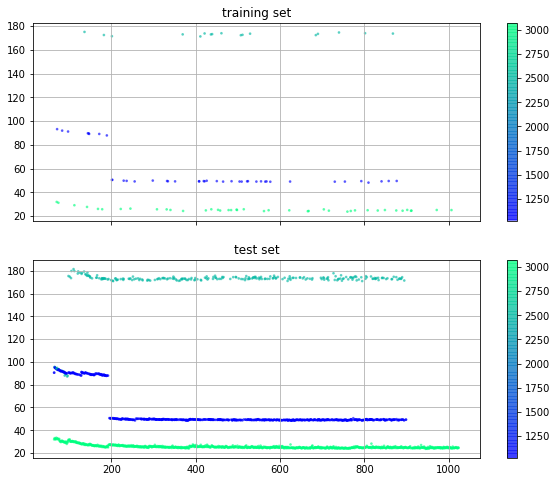

In [33]:
f, axarr = plt.subplots(2, sharex=True,figsize=(10,8))
sc0 = axarr[0].scatter(x=X_train[:,0],y=Y_train,c=X_train[:,4],s=3,alpha=0.5,cmap="winter")
sc1 = axarr[1].scatter(x=X_test[:,0],y=Y_test,c=X_test[:,4],s=3,alpha=0.5,cmap="winter")
axarr[0].set_title("training set")
axarr[1].set_title("test set")
axarr[0].grid()
axarr[1].grid()
plt.colorbar(sc0,ax=axarr[0])
plt.colorbar(sc1,ax=axarr[1])
plt.show()

In [34]:
# Fit Random Forest
clf = RandomForestRegressor(n_estimators=50)
clf = clf.fit(X_train,Y_train)

In [35]:
H_test = clf.predict(X_test)

In [36]:
mean_squared_error(Y_test, H_test)

44.170167210990137

In [37]:
H_train = clf.predict(X_train)
mean_squared_error(Y_train, H_train)

2.1181421906753561

In [38]:
# Collect MSE for various train samples numbers
MSE_df = pd.DataFrame(columns=["train_samples","test_samples","estimators","MSE"])
test_samples = 1000
# Fit Random Forest
n_estimators=50
reruns = 10
ind = 0 # DataFrame row numebr (index)
for n_estimators in range(20,81,20):
    clf = RandomForestRegressor(n_estimators=n_estimators)
    print n_estimators
    for train_samples in range(100,1000):
        mse = 0
        for i in range(0,reruns):
            X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, train_size=train_samples, shuffle = True)
            X_test = X_test[:test_samples]
            Y_test = Y_test[:test_samples]
            clf = RandomForestRegressor(n_estimators=50)
            clf = clf.fit(X_train,Y_train)
            H_test = clf.predict(X_test)
            mse += mean_squared_error(Y_test, H_test)
        mse = mse/reruns
        #print Y_train.shape,"x",Y_test.shape," ",
        MSE_df.loc[ind] = [train_samples,test_samples,n_estimators,mse]
        ind += 1

20
40
60


KeyboardInterrupt: 

In [31]:
print MSE_df.shape
MSE_df.head()

(3600, 4)


,train_samples,test_samples,estimators,MSE
0,100.0,1000.0,20.0,33.729837
1,101.0,1000.0,20.0,36.301977
2,102.0,1000.0,20.0,45.805706
3,103.0,1000.0,20.0,47.440942
4,104.0,1000.0,20.0,41.562420


In [ ]:
MSE_df.plot(kind="scatter",x="train_samples",y="MSE",c="estimators",colormap="jet",s=2)

In [64]:
df[df["batch"] == 400]

,batch,time,GPU,CUDA ver,CUDA Cap,CUDA cores,L2 size(MB),SP (GFLOPS),DP (GFLOPS),Mem (GB),Mband (GB/s)
325,400.0,26.9757,GTX TITAN X,9.0,5.2,3072,3.145728,6144,192.0,12.288,336
1247,400.0,49.2610,QuadroP2000,9.0,6.1,1024,1.310720,3000,94.7,5.000,140


In [72]:
df.loc[df["batch"] == 400][["batch","SP (GFLOPS)","Mem (GB)","Mband (GB/s)", "CUDA Cap", "CUDA cores", "L2 size(MB)","time"]]

,batch,SP (GFLOPS),Mem (GB),Mband (GB/s),CUDA Cap,CUDA cores,L2 size(MB),time
325,400.0,6144,12.288,336,5.2,3072,3.145728,26.9757
1247,400.0,3000,5.000,140,6.1,1024,1.310720,49.2610


In [73]:
test = df.loc[df["batch"] == 400][["batch","SP (GFLOPS)","Mem (GB)","Mband (GB/s)", "CUDA Cap", "CUDA cores", "L2 size(MB)"]].values
print test

[[  4.00000000e+02   6.14400000e+03   1.22880000e+01   3.36000000e+02
    5.20000000e+00   3.07200000e+03   3.14572800e+00]
 [  4.00000000e+02   3.00000000e+03   5.00000000e+00   1.40000000e+02
    6.10000000e+00   1.02400000e+03   1.31072000e+00]]


In [74]:
clf.predict(test)

array([ 25.69467,  48.98424])

In [89]:
clf.predict([[400.,6144,12.288,336,5.2,3072,3.145728]])

array([ 25.69467])

In [125]:
clf.predict([[400.,6000,5,140]]) # Несуществующее устройство :)

array([ 40.354854])